QBER without Eve: 0.00%
QBER with Eve: 52.00%


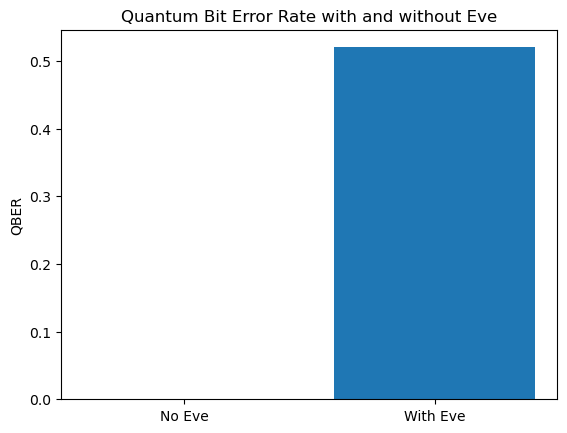

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def create_bell_state():
    """Generate a Bell state |Φ+⟩ = (|00⟩ + |11⟩) / sqrt(2)."""
    return np.array([1, 0, 0, 1]) / np.sqrt(2)

def hadamard_transform(state):
    """Apply the Hadamard transform to a quantum state."""
    H = (1/np.sqrt(2)) * np.array([[1, 1], [1, -1]])
    return np.kron(H, H).dot(state)

def apply_noise(state, snr, loss):
    """Apply noise based on SNR and simulate loss."""
    noise = np.random.normal(0, 1/snr, size=state.shape)
    loss_factor = np.exp(-loss)
    noisy_state = state * loss_factor + noise
    noisy_state /= np.linalg.norm(noisy_state)  # Normalize the state
    return noisy_state

def eavesdrop(state):
    """Simulate Eve's random measurement in either the Z or X basis, affecting entanglement."""
    basis = np.random.choice(['Z', 'X'])
    if basis == 'Z':
        # Eve measures in Z basis, resulting state collapses randomly to |0⟩ or |1⟩ for one qubit
        if np.random.rand() > 0.5:
            # Collapse Alice's qubit to |0⟩
            state = np.array([1, 0, 0, 0]) if np.random.rand() > 0.5 else np.array([0, 1, 0, 0])
        else:
            # Collapse Alice's qubit to |1⟩
            state = np.array([0, 0, 1, 0]) if np.random.rand() > 0.5 else np.array([0, 0, 0, 1])
    else:
        # Eve measures in X basis, similarly collapse Alice's qubit randomly
        H = np.array([[1, 1], [1, -1]]) / np.sqrt(2)
        plus_state = np.array([1, 1, 1, 1]) / 2 if np.random.rand() > 0.5 else np.array([1, -1, 1, -1]) / 2
        minus_state = np.array([1, 1, -1, -1]) / 2 if np.random.rand() > 0.5 else np.array([1, -1, -1, 1]) / 2
        state = np.kron(H, np.eye(2)).dot(plus_state if np.random.rand() > 0.5 else minus_state)
    return state

def measure_state(state, basis_a, basis_b):
    """Measure a state in given bases for Alice and Bob."""
    if basis_a == 'X':
        state = np.kron(np.array([[1, 1], [1, -1]]) / np.sqrt(2), np.eye(2)).dot(state)
    if basis_b == 'X':
        state = np.kron(np.eye(2), np.array([[1, 1], [1, -1]]) / np.sqrt(2)).dot(state)
    probabilities = np.abs(state)**2
    results = ['00', '01', '10', '11']
    result_index = np.random.choice(len(results), p=probabilities)
    return int(results[result_index][0]), int(results[result_index][1])

def simulate_communication(num_bits, snr, loss, with_eve=False):
    bases = ['Z', 'X']
    alice_bases = np.random.choice(bases, num_bits)
    bob_bases = np.random.choice(bases, num_bits)

    alice_results = []
    bob_results = []
    
    for i in range(num_bits):
        qubit = create_bell_state()
        if with_eve:
            qubit = eavesdrop(qubit)
        #
        qubit = apply_noise(qubit, snr, loss)
        alice_result, bob_result = measure_state(qubit, alice_bases[i], bob_bases[i])

        alice_results.append(alice_result)
        bob_results.append(bob_result)

    return alice_bases, bob_bases, alice_results, bob_results

def calculate_qber(alice_bases, bob_bases, alice_results, bob_results):
    matching_bases_indices = np.where(alice_bases == bob_bases)[0]
    matching_bases_count = len(matching_bases_indices)
    if matching_bases_count == 0:
        return 0, 0
    
    error_count = sum(alice_results[i] != bob_results[i] for i in matching_bases_indices)
    qber = error_count / matching_bases_count
    key_generation_rate = matching_bases_count / len(alice_bases)
    return qber, key_generation_rate

def run_simulation(num_bits, num_trials, snr, loss):
    qber_no_eve = []
    qber_with_eve = []

    for _ in range(num_trials):
        alice_bases, bob_bases, alice_results, bob_results = simulate_communication(num_bits, snr, loss, with_eve=False)
        qber, _ = calculate_qber(alice_bases, bob_bases, alice_results, bob_results)
        qber_no_eve.append(qber)

        alice_bases, bob_bases, alice_results, bob_results = simulate_communication(num_bits, snr, loss, with_eve=True)
        qber, _ = calculate_qber(alice_bases, bob_bases, alice_results, bob_results)
        qber_with_eve.append(qber)

    return np.mean(qber_no_eve), np.mean(qber_with_eve)

# Parameters
num_bits = 1000
num_trials = 1
snr = 500000 # Higher SNR means lower noise
loss = 0.2 # Lower loss means less attenuation

qber_no_eve, qber_with_eve = run_simulation(num_bits, num_trials, snr, loss)

print(f'QBER without Eve: {qber_no_eve * 100:.2f}%')
print(f'QBER with Eve: {qber_with_eve * 100:.2f}%')

# Plotting results
labels = ['No Eve', 'With Eve']
qber_values = [qber_no_eve, qber_with_eve]

plt.bar(labels, qber_values)
plt.ylabel('QBER')
plt.title('Quantum Bit Error Rate with and without Eve')
plt.show()


QBER with Eve attacking 0% of qubits: 30.76%
QBER with Eve attacking 10% of qubits: 32.17%
QBER with Eve attacking 50% of qubits: 40.16%
QBER with Eve attacking 100% of qubits: 49.65%


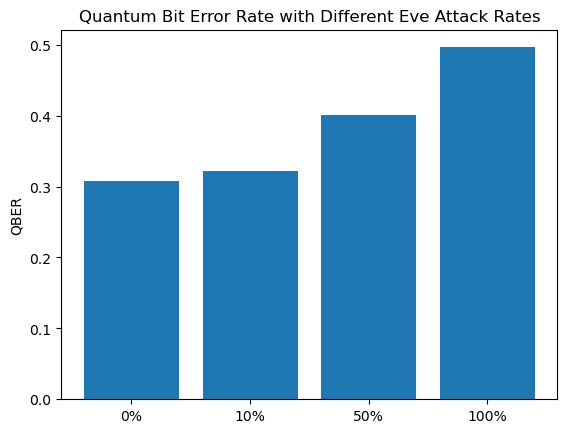

In [11]:
def simulate_communication(num_bits, snr, loss, with_eve=False, eve_attack_rate=1.0):
    """Simulate quantum communication with optional eavesdropping by Eve at a specified attack rate."""
    bases = ['Z', 'X']
    alice_bases = np.random.choice(bases, num_bits)
    bob_bases = np.random.choice(bases, num_bits)

    alice_results = []
    bob_results = []
    
    for i in range(num_bits):
        qubit = create_bell_state()
        if with_eve and np.random.rand() < eve_attack_rate:
            qubit = eavesdrop(qubit)
        qubit = apply_noise(qubit, snr, loss)
        alice_result, bob_result = measure_state(qubit, alice_bases[i], bob_bases[i])

        alice_results.append(alice_result)
        bob_results.append(bob_result)

    return alice_bases, bob_bases, alice_results, bob_results

def run_simulation(num_bits, num_trials, snr, loss, eve_attack_rates):
    results = {}
    for rate in eve_attack_rates:
        qber_with_eve = []
        for _ in range(num_trials):
            alice_bases, bob_bases, alice_results, bob_results = simulate_communication(num_bits, snr, loss, with_eve=True, eve_attack_rate=rate)
            qber, _ = calculate_qber(alice_bases, bob_bases, alice_results, bob_results)
            qber_with_eve.append(qber)
        results[rate] = np.mean(qber_with_eve)
    return results

# Parameters
num_bits = 10000
num_trials = 10
snr = 5  # Higher SNR means lower noise
loss = 1  # Lower loss means less attenuation
eve_attack_rates = [0, 0.1, 0.5, 1.0]  # Attack rates: 10%, 50%, 100%

results = run_simulation(num_bits, num_trials, snr, loss, eve_attack_rates)

# Output results
for rate, qber in results.items():
    print(f'QBER with Eve attacking {rate*100:.0f}% of qubits: {qber * 100:.2f}%')

# Plotting results
labels = [f'{rate*100:.0f}%' for rate in eve_attack_rates]
qber_values = list(results.values())

plt.bar(labels, qber_values)
plt.ylabel('QBER')
plt.title('Quantum Bit Error Rate with Different Eve Attack Rates')
plt.show()


QBER with Eve attacking 0% of qubits: 42.12%
QBER with Eve attacking 10% of qubits: 45.49%
QBER with Eve attacking 50% of qubits: 47.92%
QBER with Eve attacking 100% of qubits: 48.79%


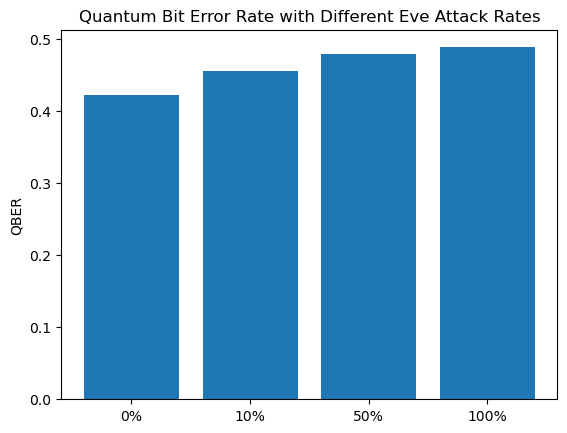

In [26]:
def apply_noise(state, snr_db, loss_db):
    """Apply noise based on SNR (in dB) and simulate loss (in dB)."""
    # Convert loss from dB to loss factor
    loss_factor = 10 ** (-loss_db / 10)
    
    # Convert SNR from dB to linear scale
    snr_linear = 10 ** (snr_db / 10)
    
    # Calculate noise standard deviation
    noise_std = np.sqrt(1 / snr_linear)
    
    # Generate noise
    noise = np.random.normal(0, noise_std, size=state.shape)
    
    # Apply loss and noise to the state
    noisy_state = state * loss_factor + noise
    
    # Normalize the state to account for loss and noise addition
    noisy_state /= np.linalg.norm(noisy_state)
    
    return noisy_state


def simulate_communication(num_bits, snr, loss, with_eve=False, eve_attack_rate=1.0):
    """Simulate quantum communication with optional eavesdropping by Eve at a specified attack rate."""
    bases = ['Z', 'X']
    alice_bases = np.random.choice(bases, num_bits)
    bob_bases = np.random.choice(bases, num_bits)

    alice_results = []
    bob_results = []
    
    for i in range(num_bits):
        qubit = create_bell_state()
        if with_eve and np.random.rand() < eve_attack_rate:
            qubit = eavesdrop(qubit)
        qubit = apply_noise(qubit, snr, loss)
        alice_result, bob_result = measure_state(qubit, alice_bases[i], bob_bases[i])

        alice_results.append(alice_result)
        bob_results.append(bob_result)

    return alice_bases, bob_bases, alice_results, bob_results

def run_simulation(num_bits, num_trials, snr, loss, eve_attack_rates):
    results = {}
    for rate in eve_attack_rates:
        qber_with_eve = []
        for _ in range(num_trials):
            alice_bases, bob_bases, alice_results, bob_results = simulate_communication(num_bits, snr, loss, with_eve=True, eve_attack_rate=rate)
            qber, _ = calculate_qber(alice_bases, bob_bases, alice_results, bob_results)
            qber_with_eve.append(qber)
        results[rate] = np.mean(qber_with_eve)
    return results

# Parameters
num_bits = 1000
num_trials = 1
snr = 80  # Higher SNR means lower noise
loss = 40  # Lower loss means less attenuation
eve_attack_rates = [0, 0.1, 0.5, 1.0]  # Attack rates: 10%, 50%, 100%

results = run_simulation(num_bits, num_trials, snr, loss, eve_attack_rates)

# Output results
for rate, qber in results.items():
    print(f'QBER with Eve attacking {rate*100:.0f}% of qubits: {qber * 100:.2f}%')

# Plotting results
labels = [f'{rate*100:.0f}%' for rate in eve_attack_rates]
qber_values = list(results.values())

plt.bar(labels, qber_values)
plt.ylabel('QBER')
plt.title('Quantum Bit Error Rate with Different Eve Attack Rates')
plt.show()


QBER with Eve attacking 0% of qubits: 13.60%
QBER with Eve attacking 10% of qubits: 17.11%
QBER with Eve attacking 50% of qubits: 31.73%
QBER with Eve attacking 100% of qubits: 49.91%


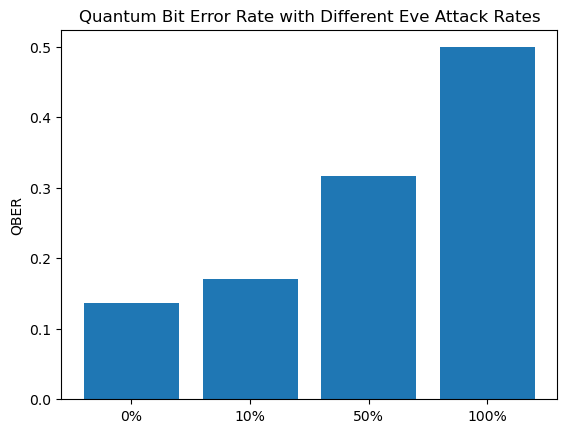

In [16]:
def apply_noise(state, snr_db, loss_db):
    """
    Apply noise based on SNR in dB and simulate loss in dB.
    
    :param state: Quantum state represented as a numpy array.
    :param snr_db: Signal-to-Noise Ratio in decibels.
    :param loss_db: Loss in decibels.
    :return: Quantum state after noise and loss have been applied.
    """
    # Convert loss from dB to a linear scale factor
    loss_factor = 10 ** (-loss_db / 10)

    # Apply loss to the quantum state
    state_after_loss = state * loss_factor

    # Calculate the power of the state after loss
    signal_power = np.mean(np.abs(state_after_loss)**2)

    # Convert SNR from dB to linear scale
    snr_linear = 10 ** (snr_db / 10)

    # Calculate noise power based on the signal power and linear SNR
    noise_power = signal_power / snr_linear

    # Generate Gaussian noise with calculated noise power
    noise = np.sqrt(noise_power) * (np.random.randn(*state.shape))

    # Add noise to the attenuated state
    noisy_state = state_after_loss + noise

    # Normalize the state to ensure it remains a valid quantum state
    noisy_state /= np.linalg.norm(noisy_state)

    return noisy_state


def simulate_communication(num_bits, snr, loss, with_eve=False, eve_attack_rate=1.0):
    """Simulate quantum communication with optional eavesdropping by Eve at a specified attack rate."""
    bases = ['Z', 'X']
    alice_bases = np.random.choice(bases, num_bits)
    bob_bases = np.random.choice(bases, num_bits)

    alice_results = []
    bob_results = []
    
    for i in range(num_bits):
        qubit = create_bell_state()
        if with_eve and np.random.rand() < eve_attack_rate:
            qubit = eavesdrop(qubit)
        qubit = apply_noise(qubit, snr, loss)
        alice_result, bob_result = measure_state(qubit, alice_bases[i], bob_bases[i])

        alice_results.append(alice_result)
        bob_results.append(bob_result)

    return alice_bases, bob_bases, alice_results, bob_results

def run_simulation(num_bits, num_trials, snr, loss, eve_attack_rates):
    results = {}
    for rate in eve_attack_rates:
        qber_with_eve = []
        for _ in range(num_trials):
            alice_bases, bob_bases, alice_results, bob_results = simulate_communication(num_bits, snr, loss, with_eve=True, eve_attack_rate=rate)
            qber, _ = calculate_qber(alice_bases, bob_bases, alice_results, bob_results)
            qber_with_eve.append(qber)
        results[rate] = np.mean(qber_with_eve)
    return results

# Parameters
num_bits = 10000
num_trials = 10
snr = 5  # Higher SNR means lower noise
loss = 10  # Lower loss means less attenuation
eve_attack_rates = [0, 0.1, 0.5, 1.0]  # Attack rates: 10%, 50%, 100%

results = run_simulation(num_bits, num_trials, snr, loss, eve_attack_rates)

# Output results
for rate, qber in results.items():
    print(f'QBER with Eve attacking {rate*100:.0f}% of qubits: {qber * 100:.2f}%')

# Plotting results
labels = [f'{rate*100:.0f}%' for rate in eve_attack_rates]
qber_values = list(results.values())

plt.bar(labels, qber_values)
plt.ylabel('QBER')
plt.title('Quantum Bit Error Rate with Different Eve Attack Rates')
plt.show()


QBER with Eve attacking 0% of qubits: 15.48%


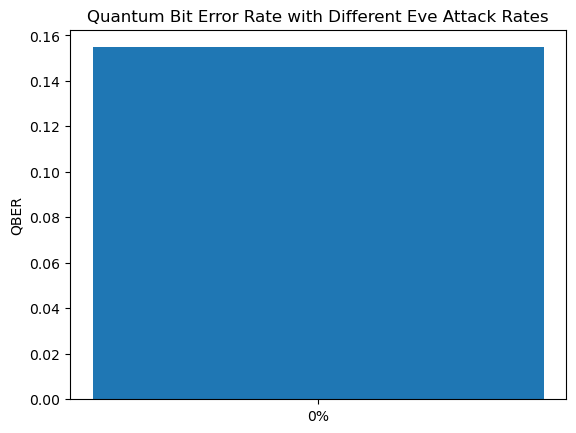

In [23]:
def apply_noise(state, snr_db, loss_db):
    """
    Apply noise based on SNR in dB and simulate loss in dB.
    
    :param state: Quantum state represented as a numpy array.
    :param snr_db: Signal-to-Noise Ratio in decibels.
    :param loss_db: Loss in decibels.
    :return: Quantum state after noise and loss have been applied.
    """
    # Convert loss from dB to a linear scale factor
    loss_factor = 10 ** (-loss_db / 10)

    # Apply loss to the quantum state
    state_after_loss = state * loss_factor

    # Calculate the power of the state after loss
    signal_power = np.mean(np.abs(state_after_loss)**2)

    # Convert SNR from dB to linear scale
    snr_linear = 10 ** (snr_db / 10)

    # Calculate noise power based on the signal power and linear SNR
    noise_power = signal_power / snr_linear

    # Generate Gaussian noise with calculated noise power
    noise = np.sqrt(noise_power) * (np.random.randn(*state.shape))

    # Add noise to the attenuated state
    noisy_state = state_after_loss + noise

    # Normalize the state to ensure it remains a valid quantum state
    noisy_state /= np.linalg.norm(noisy_state)

    return noisy_state


def simulate_communication(num_bits, snr, loss, with_eve=False, eve_attack_rate=1.0):
    """Simulate quantum communication with optional eavesdropping by Eve at a specified attack rate."""
    bases = ['Z', 'X']
    alice_bases = np.random.choice(bases, num_bits)
    bob_bases = np.random.choice(bases, num_bits)

    alice_results = []
    bob_results = []
    
    for i in range(num_bits):
        qubit = create_bell_state()
        if with_eve and np.random.rand() < eve_attack_rate:
            qubit = eavesdrop(qubit)
        qubit = apply_noise(qubit, snr, loss)
        alice_result, bob_result = measure_state(qubit, alice_bases[i], bob_bases[i])

        alice_results.append(alice_result)
        bob_results.append(bob_result)

    return alice_bases, bob_bases, alice_results, bob_results

def run_simulation(num_bits, num_trials, snr, loss, eve_attack_rates):
    results = {}
    for rate in eve_attack_rates:
        qber_with_eve = []
        for _ in range(num_trials):
            alice_bases, bob_bases, alice_results, bob_results = simulate_communication(num_bits, snr, loss, with_eve=True, eve_attack_rate=rate)
            qber, _ = calculate_qber(alice_bases, bob_bases, alice_results, bob_results)
            qber_with_eve.append(qber)
        results[rate] = np.mean(qber_with_eve)
    return results

# Parameters
num_bits = 1000
num_trials = 1
snr = 5  # Higher SNR means lower noise
loss = 200  # Lower loss means less attenuation
eve_attack_rates = [0]  # Attack rates: 10%, 50%, 100%

results = run_simulation(num_bits, num_trials, snr, loss, eve_attack_rates)

# Output results
for rate, qber in results.items():
    print(f'QBER with Eve attacking {rate*100:.0f}% of qubits: {qber * 100:.2f}%')

# Plotting results
labels = [f'{rate*100:.0f}%' for rate in eve_attack_rates]
qber_values = list(results.values())

plt.bar(labels, qber_values)
plt.ylabel('QBER')
plt.title('Quantum Bit Error Rate with Different Eve Attack Rates')
plt.show()
